In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 100 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 300  

In [ ]:

MAX_FEATURES = 166289
MAX_WORDS = MAX_SEQUENCE_LENGTH

In [ ]:
y_train = df_train['target'].values
y_test = df_test['target'].values
X_train_text = df_train['question_text'].values
X_val_text = df_test['question_text'].values
#X_test_text = df_test['clean_question'].values
print(X_train_text.shape,y_train.shape)
#print(X_test_text.shape)

(128000,) (128000,)


In [ ]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
#X_test = tokenizer.texts_to_sequences(X_test_text)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
                    
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score, precision_score, recall_score

from tensorflow import keras
from keras.layers import Input
from keras import Model
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import Callback

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen=MAX_WORDS)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_WORDS)
#X_test = sequence.pad_sequences(X_test, maxlen=MAX_WORDS)
print(X_train.shape,X_val.shape)

(128000, 100) (32000, 100)


In [ ]:

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [ ]:
gloveEmbed = get_embed_mat('glove.840B.300d.txt', MAX_FEATURES, 300)

Found 2196016 word vectors.


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
word_index = tokenizer.word_index
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[gloveEmbed],
                            input_length=MAX_WORDS,
                            trainable=False)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(300, return_sequences = True)))
model.add(Bidirectional(LSTM(300, return_sequences = True)))
model.add(Bidirectional(LSTM(300, return_sequences = True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer=opt,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          16039200  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 600)          1442400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 600)          2162400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 600)          2162400   
_________________________________________________________________
global_max_pooling1d (Global (None, 600)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                9616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0

In [ ]:
model.fit(X_train, y_train,
          epochs=5, batch_size=64, verbose=1)

Epoch 1/5
2000/2000 [==============================] - 212s 106ms/step - loss: 0.3090 - accuracy: 0.8765
Epoch 2/5
2000/2000 [==============================] - 219s 109ms/step - loss: 0.2751 - accuracy: 0.8929
Epoch 3/5
2000/2000 [==============================] - 219s 109ms/step - loss: 0.2587 - accuracy: 0.9000
Epoch 4/5
2000/2000 [==============================] - 219s 109ms/step - loss: 0.2461 - accuracy: 0.9050
Epoch 5/5
2000/2000 [==============================] - 218s 109ms/step - loss: 0.2345 - accuracy: 0.9102


In [ ]:
preds = model.predict(X_val, batch_size = 64, verbose = 1)

500/500 [==============================] - 19s 39ms/step


In [ ]:
def line_search_f1_score(y_score, y_test):
    max_f1_score = 0
    opt_threshold = 0
    for threshold in [i*0.01 for i in range(100)]:
        y_preds = y_score > threshold
        score = f1_score(y_preds, y_test)
        if max_f1_score < score:
            max_f1_score = score
            opt_threshold = threshold
    return max_f1_score, opt_threshold

In [ ]:
max_f1_score, threshold = line_search_f1_score(preds, y_test)

In [ ]:
print(max_f1_score,threshold)

0.9032533463426533 0.48


In [ ]:
predictions = [1 if x>0.48 else 0 for x in preds]

0.90084375


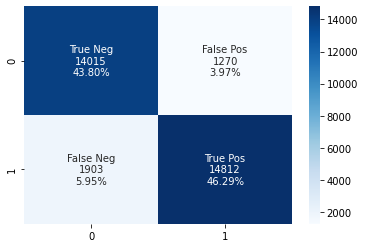

In [ ]:
cf_matrix = confusion_matrix(predictions, y_test)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

print(accuracy_score(predictions, y_test))

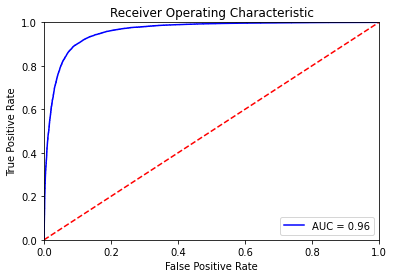

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


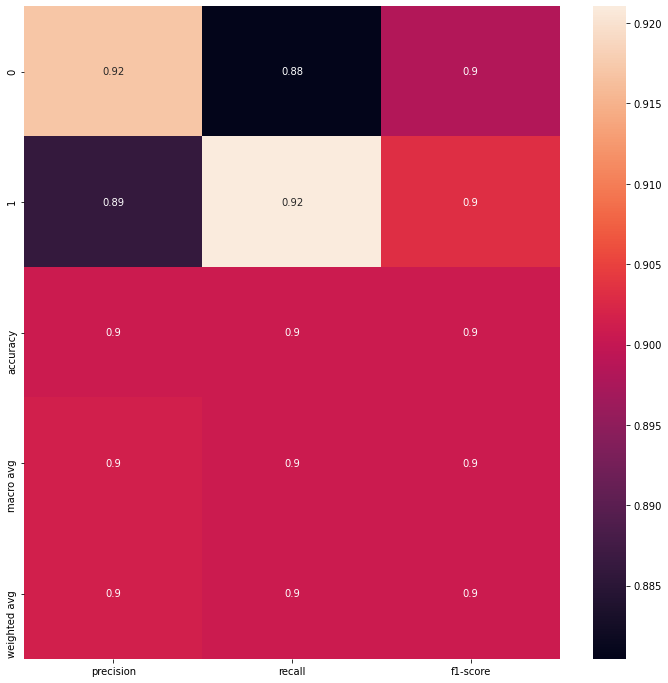

In [ ]:
from sklearn.metrics import classification_report

clf_report = classification_report(y_test,
                                   predictions,
                                   labels=[0,1],
                                   output_dict=True)

fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,ax=ax,square = False)